In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-06-20 17:36:27.904470
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
 '13342500' #'13311000' #'13340600'
 #'13154500' #'13310850'
 # '12322000'
 # "13296000" #"13311450"
               #'13190500' #'12305000' #'13340000' #'13317660'
#

 #'13192200'
 #'13211205'
 #'13311250'
         #     '13341050'
# '13150430'
          #    '13092747'
#  '13304050'
  #'13307000' #
  #
   #'13176400' #
# '13310800'
#  '12305000'


  #


  #
              #
   #
              #
            #  '13213000'# not enough data
#

   #
    #  #
   #
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )





dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year


dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]


shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Print the cleaned DataFrame
print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

# gap

# Calculate time difference between consecutive dates
df_cleaned['Gap'] = df_cleaned['Date'].diff()

# Filter rows where the gap is more than expected (e.g., > 1 day)
expected_freq = pd.Timedelta(days=1)
gaps = df_cleaned[df_cleaned['Gap'] > expected_freq]

print("gaps",gaps)


site_info_df:   agency_cd   site_no                       station_nm site_tp_cd  lat_va  \
0      USGS  13342500  CLEARWATER RIVER AT SPALDING ID         ST  462654   

   long_va  dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ...  \
0  1164939   46.448333    -116.8275             N            S  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0              C   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                    geometry  
0           NaN          NaN         NaN  POINT (-116.8275 46.44833)  

[1 rows x 43 columns]
station_nm: CLEARWATER RIVER AT SPALDING ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:            tmean   site_no       Date  00010_Mean  00060_Mean
1613    6.865000  13342500 2000-03-01         5.7     19600.0
1614    7.510000  13342500 2000-03-02         5.8     19000.0
1615    8.782001  13342500 2000-03-03         6.4     16400.0
1616    8.031000  133425

/tmp/ipython-input-3-909750794.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
#print(df.head())
print(df.tail())
#print(df.shape)

(4539, 6)
(4539, 6)

DataFrame after Normalization Head:
          tmean   site_no       Date  00010_Mean  00060_Mean    Gap
10558  0.603163  13342500 2024-08-27    0.530055    0.080147 1 days
10559  0.564236  13342500 2024-08-28    0.502732    0.081194 1 days
10560  0.642958  13342500 2024-08-29    0.513661    0.081194 1 days
10561  0.734219  13342500 2024-08-30    0.524590    0.080147 1 days
10562  0.792245  13342500 2024-08-31    0.524590    0.081194 1 days


/tmp/ipython-input-6-46837385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['Date'] = pd.to_datetime(df_12['Date'])


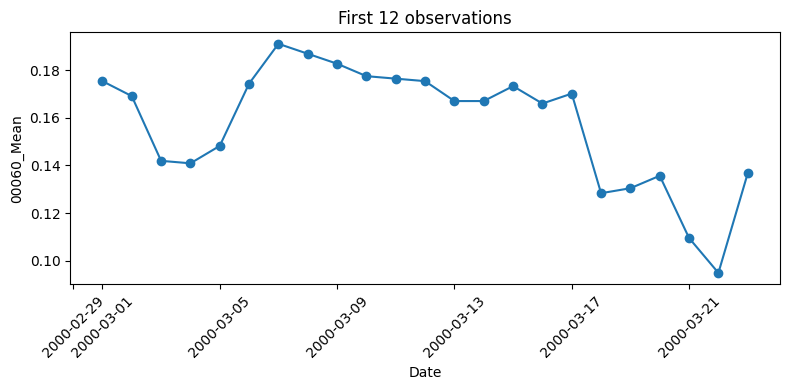

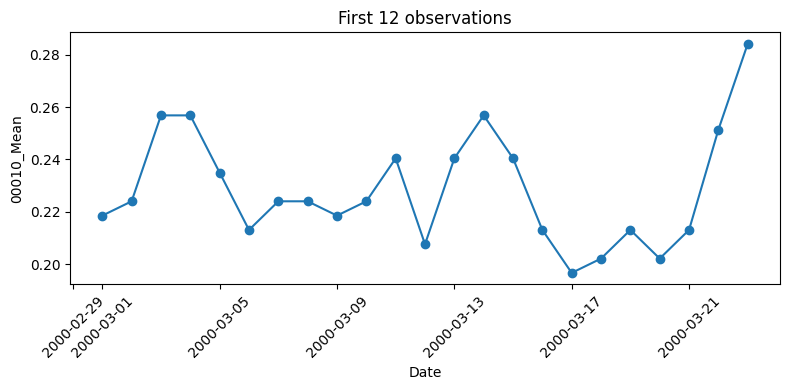

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your full DataFrame is called `df`
# 1) Keep only the first 12 rows
df_12 = df.head(23)        # or df.iloc[:12]

# 2) Make sure 'Date' is datetime (skip if it already is)
df_12['Date'] = pd.to_datetime(df_12['Date'])

# 3) Plot
plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00060_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00060_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00010_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  54 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.35068756 0.17548455 0.21857923]
 [0.36624848 0.16919853 0.22404372]
 [0.39693606 0.14195914 0.2568306 ]
 ...
 [0.64295771 0.08119434 0.5136612 ]
 [0.73421948 0.08014667 0.52459016]
 [0.79224479 0.08119434 0.52459016]]
X [[[0.35068756 0.17548455]
  [0.36624848 0.16919853]
  [0.39693606 0.14195914]
  ...
  [0.44002412 0.45206915]
  [0.39201445 0.4468308 ]
  [0.38262966 0.3996857 ]]

 [[0.36624848 0.16919853]
  [0.39693606 0.14195914]
  [0.37881783 0.14091147]
  ...
  [0.39201445 0.4468308 ]
  [0.38262966 0.3996857 ]
  [0.37951748 0.36616029]]

 [[0.39693606 0.14195914]
  [0.37881783 0.14091147]
  [0.29013268 0.14824515]
  ...
  [0.38262966 0.3996857 ]
  [0.37951748 0.36616029]
  [0.46142339 0.34625458]]

 ...

 [[0.7745319  0.12833944]
  [0.82293359 0.14405448]
  [0.86214228 0.13776847]
  ...
  [0.60316278 0.08014667]
  [0.5642364  0.08119434]
  [0.64295771 0.08119434]]

 [[0.82293359 0.14405448]
  [0.86214228 0.13776847]
  [0.89603731 0.12100576]
  ...
  [0.5642364  0.08119

In [8]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")


print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")


print(f"Y Test samples: {len(Y_test)}")

Train samples: 3588
Test samples: 897
 Y Train samples: 3588
Y Test samples: 897


In [9]:
print("X_train[0]:", X_train[0])
print("Y_train[0]:", Y_train[0])


print("df.head(6)",df.head(6))
#print("X:", X)
#print("Y:", Y)


#print("X_train:", X_train)
#print("Y_train:", Y_train)
print("Y_train.shape:", Y_train.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train[0]: [[0.35068756 0.17548455]
 [0.36624848 0.16919853]
 [0.39693606 0.14195914]
 [0.37881783 0.14091147]
 [0.29013268 0.14824515]
 [0.27095295 0.17443688]
 [0.30653799 0.19119958]
 [0.33370325 0.18700891]
 [0.30632085 0.18281823]
 [0.36272616 0.17757988]
 [0.31792521 0.17653222]
 [0.29951749 0.17548455]
 [0.39840771 0.1671032 ]
 [0.3539445  0.1671032 ]
 [0.34598311 0.17338921]
 [0.33018093 0.16605553]
 [0.30357056 0.1702462 ]
 [0.29770807 0.12833944]
 [0.2710977  0.13043478]
 [0.27963811 0.13567313]
 [0.37802169 0.1094814 ]
 [0.47305185 0.09481404]
 [0.32335343 0.1367208 ]
 [0.37034981 0.14614982]
 [0.35990348 0.12624411]
 [0.39657417 0.11576742]
 [0.41611579 0.11471975]
 [0.36279855 0.14091147]
 [0.2951749  0.15557884]
 [0.35382387 0.13776847]
 [0.38400481 0.12414877]
 [0.48120626 0.11681509]
 [0.48668274 0.11681509]
 [0.55027742 0.17443688]
 [0.4952714  0.20586695]
 [0.37372737 0.28444212]
 [0.38142338 0.3053955 ]
 [0.41182145 0.28444212]
 [0.48395657 0.27396543]
 [0.49872133 

/tmp/ipython-input-10-2831626437.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([array1, array2],


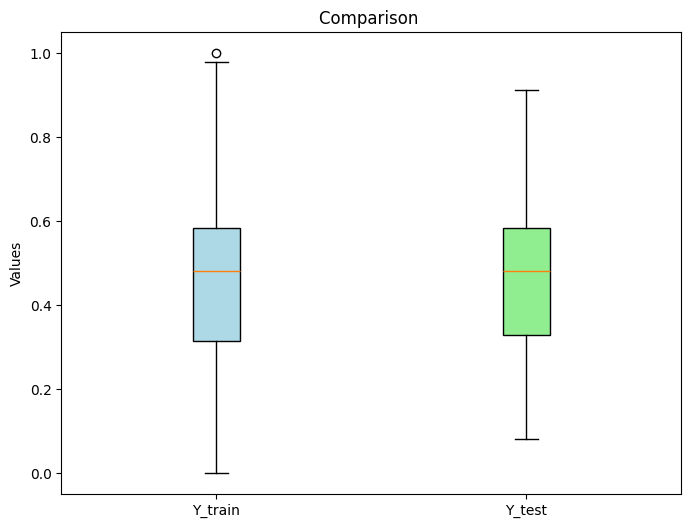

Number of zeros Y_train: 1


In [10]:


import matplotlib.pyplot as plt
import numpy as np  # Only needed if you're creating example data

# Example data (replace with your actual arrays)
array1 = Y_train
array2 =  Y_test

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create the boxplot
boxplot = plt.boxplot([array1, array2],
                     patch_artist=True,
                     labels=['Y_train', 'Y_test'])

# Customize colors (optional)
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title('Comparison ')
plt.ylabel('Values')

# Show the plot
plt.show()

num_zeros = Y_train.size - np.count_nonzero(Y_train)

print(f"Number of zeros Y_train: {num_zeros}")

In [11]:
model_params = {
    'h1': 256,
    'h2': 100,
   # 'learning_rate': 0.0001,
   'dropout_rate_1': 0.05,
   'dropout_rate_2': 0.025,
   # 'loss_function': 'mean_squared_error',


}

h1 = model_params['h1']
h2 = model_params['h2']
#learning_rate = model_params['learning_rate']
d1 = model_params['dropout_rate_1']
d2 = model_params['dropout_rate_2']


In [12]:
# --- 5. Build LSTM Model ---


learning_rate = 0.0001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)
#d1 = 0.1
#d2 = 0.1

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 54, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,117 (1.56 MB)

 Trainable params: 408,117 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x783f2ca8e480>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x783f2ca8e480>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x783f2ca8eac0>


Epoch 1/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0366 - val_loss: 0.0100
Epoch 2/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 3/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 4/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 5/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 6/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 7/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 8/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 9/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 10/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 11/105
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 12/105
180/180 ━━━━━━━━━━━━━━━━━━

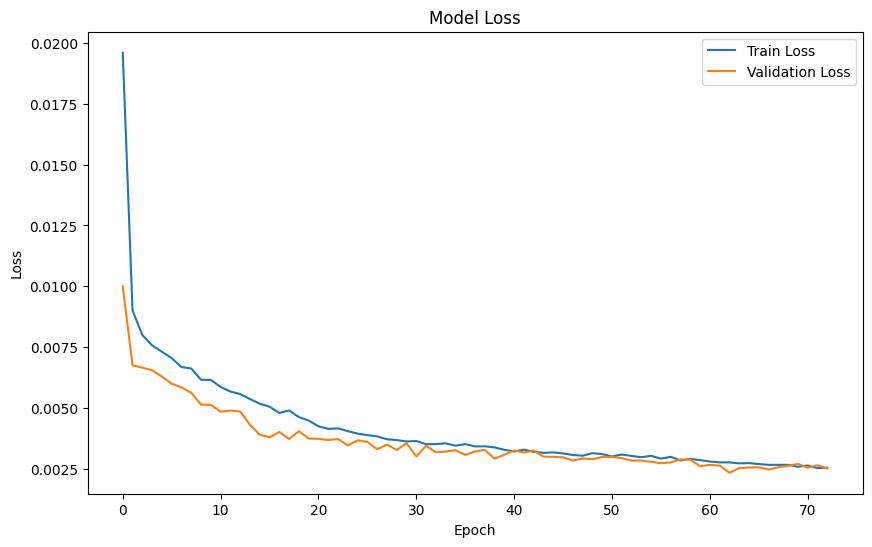

In [13]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  16
history = model.fit(X_train, Y_train,
                    epochs=105, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

#print(history)
# Print the epoch the model stopped at
print(f"Training stopped at epoch: {len(history.history['loss'])}")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 54, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224,353 (4.67 MB)

 Trainable params: 408,117 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 816,236 (3.11 MB)

In [15]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0024
Test Loss (MSE): 0.0035


In [16]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Shape of Y_pred_scaled: (897, 1)
Shape of Y_test: (897,)
Shape of X_test: (897, 55, 2)
Test RMSE: 1.0894
Test bias: -0.1256
correlation 0.9425065446834047
3.237848
3.062293038607327


In [17]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (897, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (897, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [18]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print("summer_df.tail()",summer_df.tail())

summer_df.to_csv( ( model_site[0] + "summer_df.csv") )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of           tmean   site_no       Date  00010_Mean  00060_Mean    Gap
1613   0.350688  13342500 2000-03-01    0.218579    0.175485    NaT
1614   0.366248  13342500 2000-03-02    0.224044    0.169199 1 days
1615   0.396936  13342500 2000-03-03    0.256831    0.141959 1 days
1616   0.378818  13342500 2000-03-04    0.256831    0.140911 1 days
1617   0.290133  13342500 2000-03-05    0.234973    0.148245 1 days
...         ...       ...        ...         ...         ...    ...
10558  0.603163  13342500 2024-08-27    0.530055    0.080147 1 days
10559  0.564236  13342500 2024-08-28    0.502732    0.081194 1 days
10560  0.642958  13342500 2024-08-29    0.513661    0.081194 1 days
10561  0.734219  13342500 2024-08-30    0.524590    0.080147 1 days
10562  0.792245  13342500 2024-08-31    0.524590    0.081194 1 days

[4539 rows x 6 columns]>
3588
4485
dt_ys.tail()           tmean   site_no       Date  00010_Mean  00060_Mean    Gap  \
10558  0.603163  

/tmp/ipython-input-18-1200362995.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
/tmp/ipython-input-18-1200362995.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
/tmp/ipython-input-18-1200362995.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

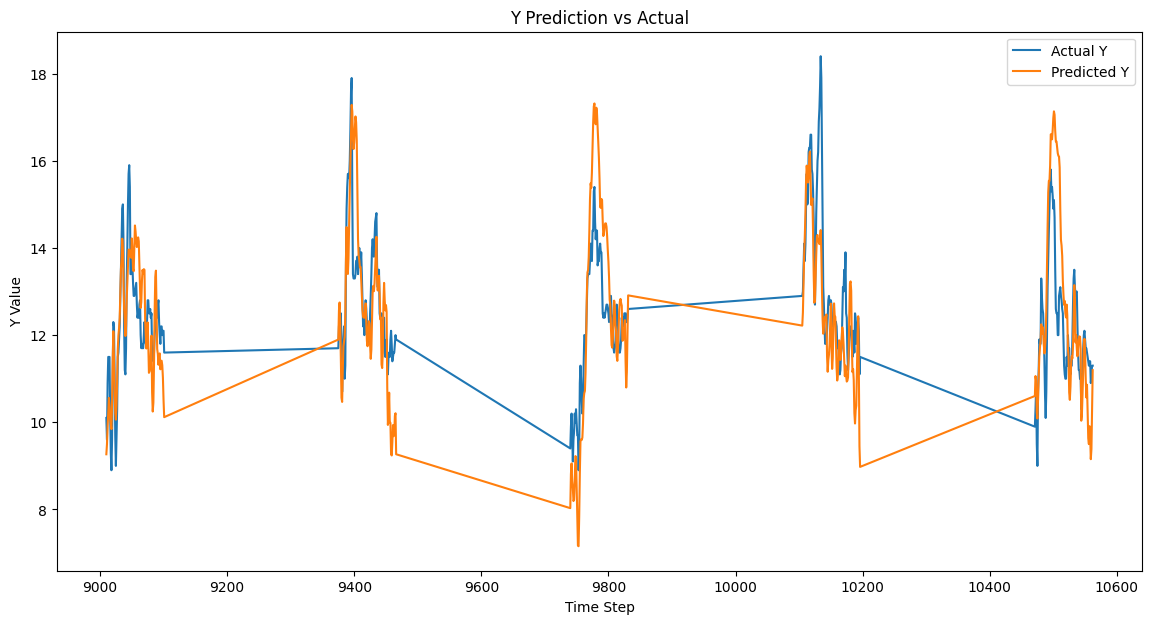

In [19]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

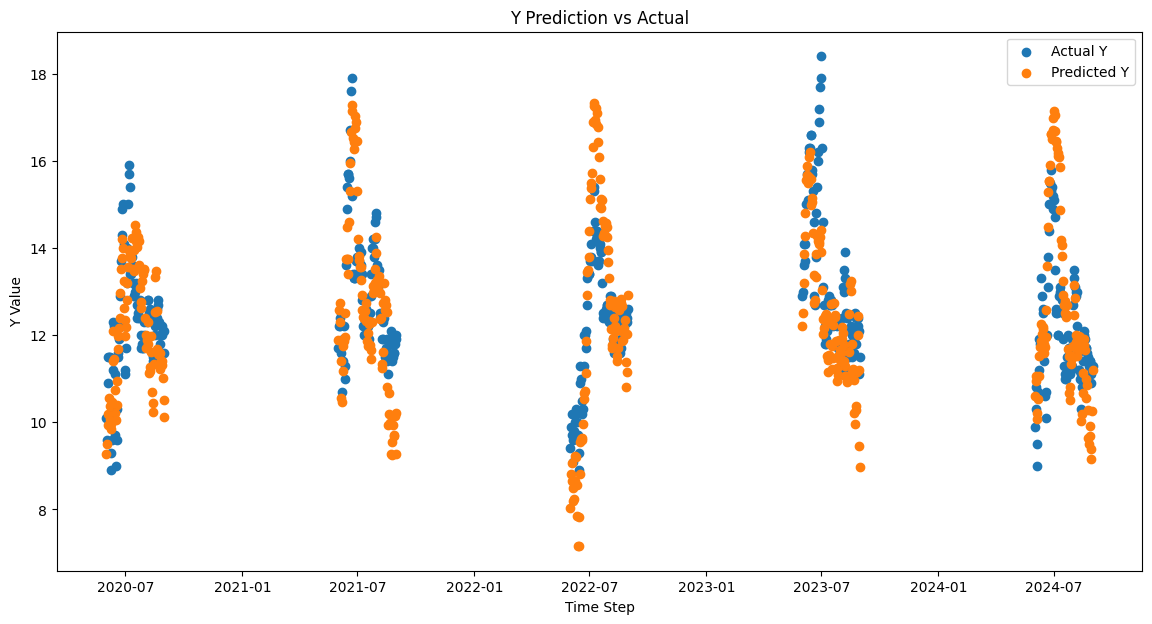

In [20]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

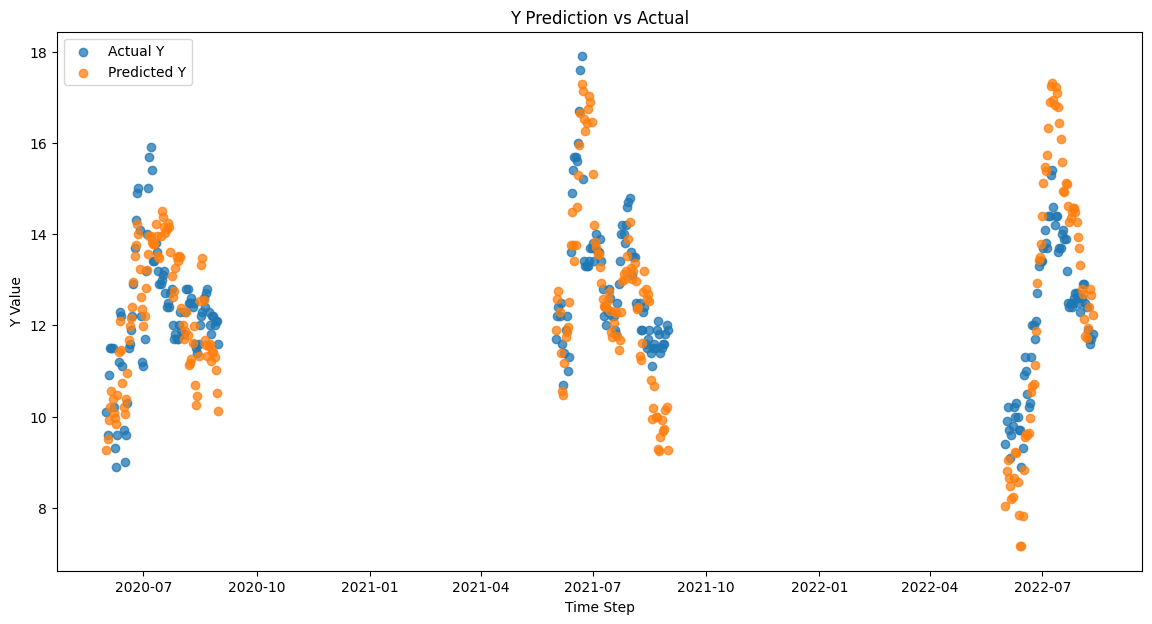

In [21]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

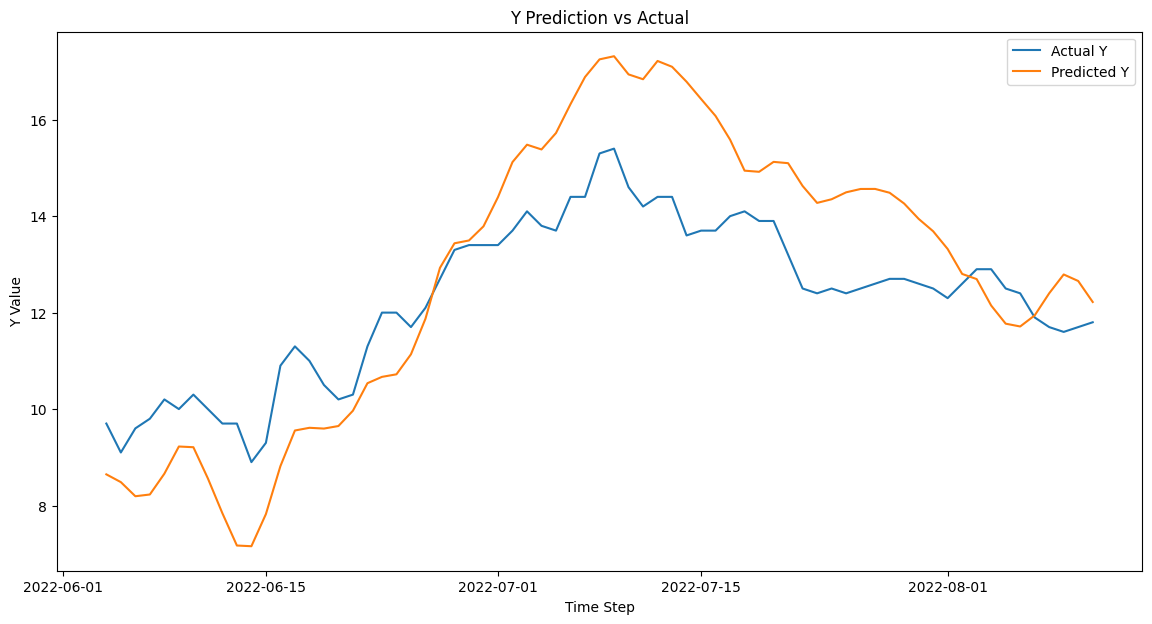

In [22]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

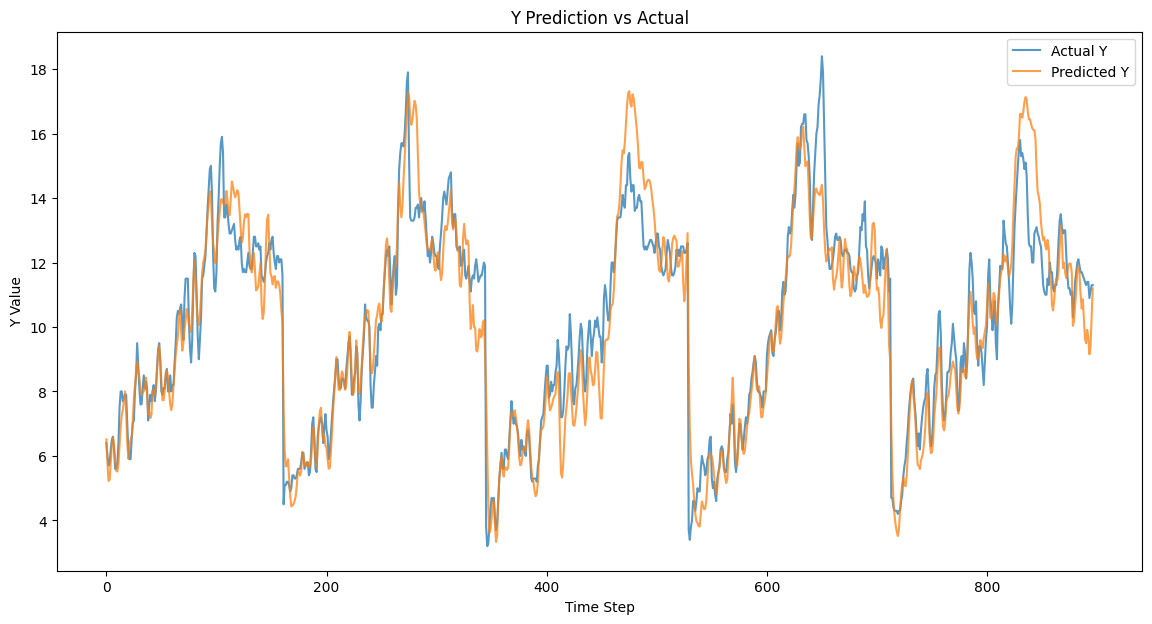

In [23]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()


In [24]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


                current_time model_site         train_month   h1   h2    d1  \
0 2025-06-20 17:36:27.904470   13342500  [3, 4, 5, 6, 7, 8]  256  100  0.05   

      d2  batch  look_back                                          optimizer  \
0  0.025     16         54  <keras.src.optimizers.adam.Adam object at 0x78...   

   learning_rate        r2      rmse      bias  std_ratio  correlation  \
0         0.0001  0.873452  1.333469 -0.125609   1.057328     0.942507   

                    KGE            KGE_r_comp        KGE_alpha_comp  \
0  [0.9178625160343132]  [0.9425065446834051]  [1.0573279573904804]   

          KGE_beta_comp  
0  [0.9875672139322099]  


In [25]:
#model.save( (model_site[0]+'_lstm_model.h5') )

         tmean   site_no       Date  00010_Mean  00060_Mean    Gap     Y_pred  \
9010  0.546391  13342500 2020-06-01    0.459016    0.569408 1 days   9.266425   
9011  0.616994  13342500 2020-06-02    0.431694    0.442640 1 days   9.501607   
9012  0.614425  13342500 2020-06-03    0.502732    0.396543 1 days   9.933983   
9013  0.587925  13342500 2020-06-04    0.535519    0.379780 1 days  10.199740   
9014  0.629252  13342500 2020-06-05    0.535519    0.350445 1 days  10.560046   

      Y_test_original      bias  
9010             10.1 -0.833575  
9011              9.6 -0.098393  
9012             10.9 -0.966017  
9013             11.5 -1.300260  
9014             11.5 -0.939954  


/tmp/ipython-input-26-2963098943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


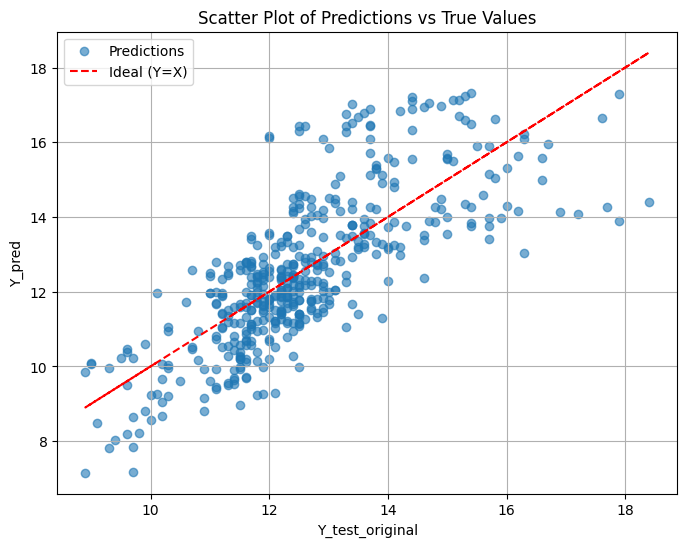

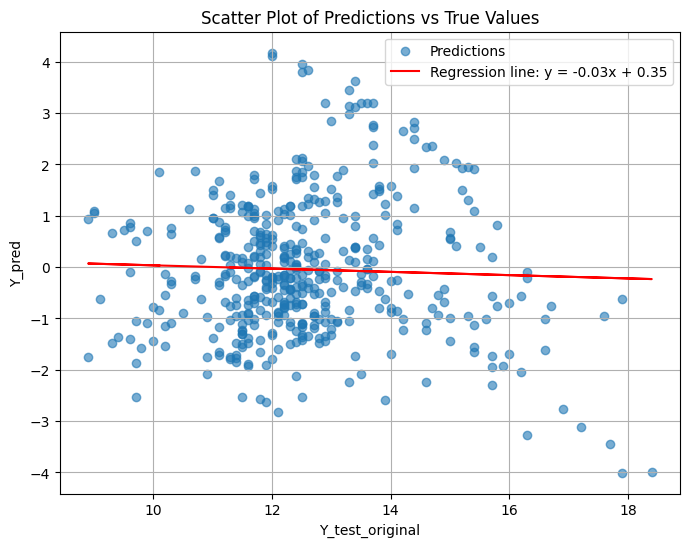

In [26]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

          tmean   site_no       Date  00010_Mean  00060_Mean    Gap  \
9010   0.546391  13342500 2020-06-01    0.459016    0.569408 1 days   
9011   0.616994  13342500 2020-06-02    0.431694    0.442640 1 days   
9012   0.614425  13342500 2020-06-03    0.502732    0.396543 1 days   
9013   0.587925  13342500 2020-06-04    0.535519    0.379780 1 days   
9014   0.629252  13342500 2020-06-05    0.535519    0.350445 1 days   
...         ...       ...        ...         ...         ...    ...   
10558  0.603163  13342500 2024-08-27    0.530055    0.080147 1 days   
10559  0.564236  13342500 2024-08-28    0.502732    0.081194 1 days   
10560  0.642958  13342500 2024-08-29    0.513661    0.081194 1 days   
10561  0.734219  13342500 2024-08-30    0.524590    0.080147 1 days   
10562  0.792245  13342500 2024-08-31    0.524590    0.081194 1 days   

          Y_pred  Y_test_original      bias  
9010    9.266425             10.1 -0.833575  
9011    9.501607              9.6 -0.098393  
9012    9

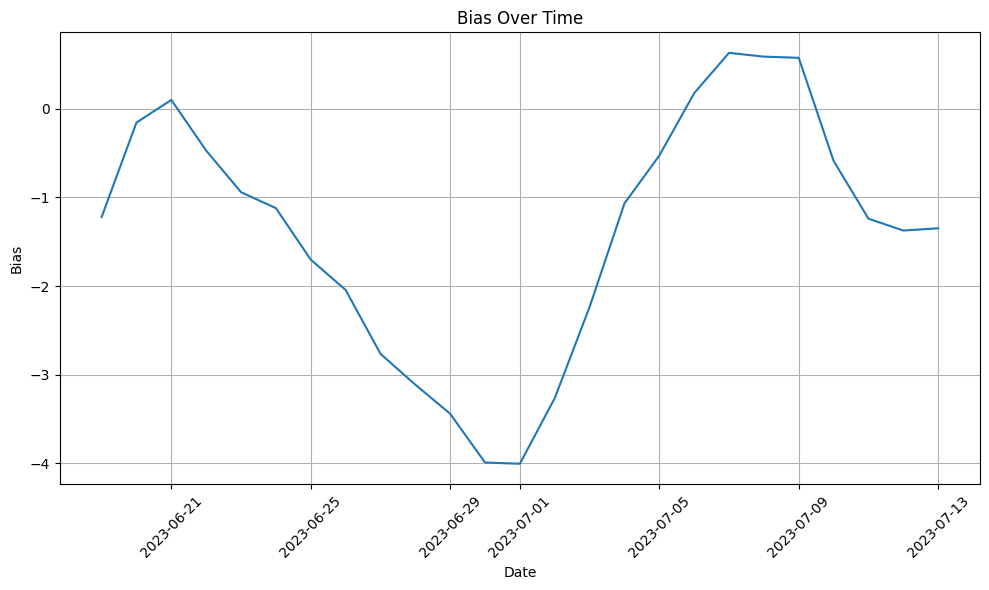

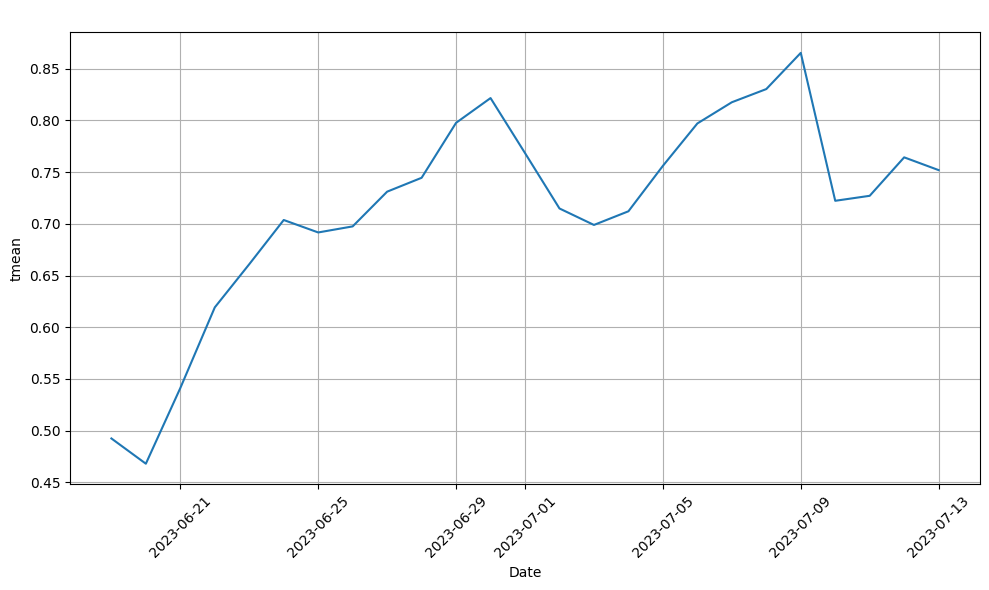

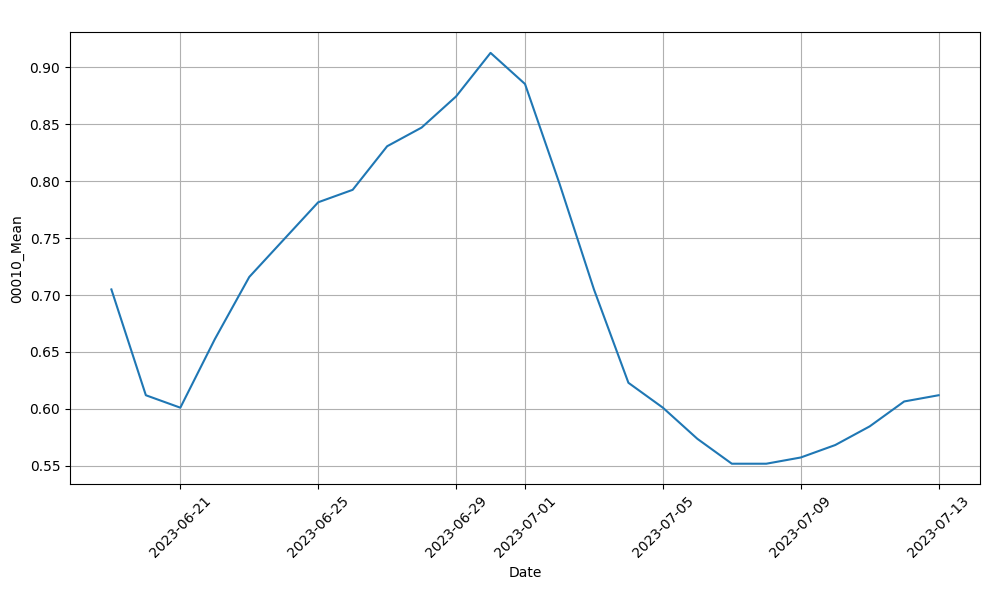

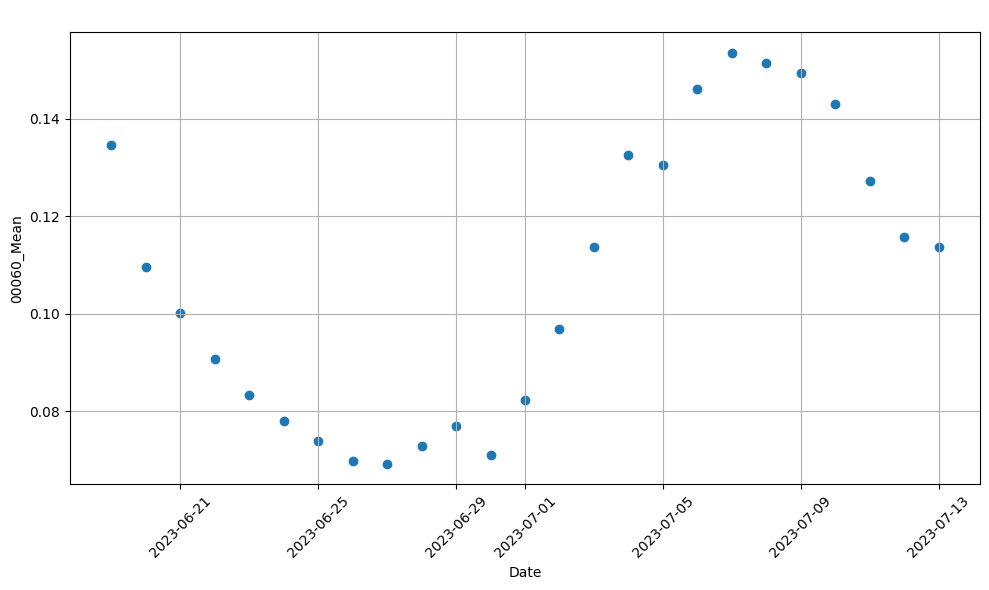

In [27]:
print(summer_df)

# --- prep ---
#summer_df['Date'] = summer_df.to_datetime( subset_rows['Date'])      # make sure Date is datetime
summer_df = summer_df.sort_values('Date').reset_index(drop=True)

# --- locate the peak bias ---
idx_peak   = summer_df['bias'].idxmin()             # row index of the max bias
date_peak  = summer_df.at[idx_peak, 'Date']         # corresponding date

# ------- OPTION 1: ±12 *days* around that date -------
start_day  = date_peak - pd.Timedelta(days=12)
end_day    = date_peak + pd.Timedelta(days=12)

subset_days = summer_df[(summer_df['Date'] >= start_day) & ( summer_df['Date'] <= end_day)].copy()

# ------- OPTION 2: ±12 *rows* around that row index -------
start_idx  = max(idx_peak - 12, 0)
end_idx    = min(idx_peak + 12, len(df) - 1)

subset_rows = summer_df.loc[start_idx : end_idx].copy()
subset_rows


# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows['bias'])

# Customizing the plot
plt.title('Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Bias')
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()





####

# Plotting
yvar = 'tmean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00010_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00060_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030